In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [66]:
# define helper functions for mse_loss
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def rho(z):
    return 2 * sigmoid(z) - 1

def myPerceptron(X, y, eta=1.0, max_iters=1000, init_weights=None, shuffle=False, pocket=False, random_seed=None, mse_loss=False, eps=1e-6):
    """
    X = covariate matrix
    y = labels
    eta = learning rate
    max_iters = max iterations
    init_weights = initial weights
    shuffle = whether we shuffle or not
    pocket = whether we choose best or last sol
    mse_loss = whether or not to use MSE loss function
    """
    X = np.column_stack((np.ones(X.shape[0]), X)) # add intercept column for X
    if init_weights is not None:
        weights = init_weights.copy()
    else:
        weights = np.ones(X.shape[1])
        
    misclassification_rates = []    # initialize misclass rates
    average_costs = []              # initialize avg cost 
    n = len(y)  
    best_err = np.inf

    # run through epochs
    for epoch in range(max_iters):
        # shuffle if specified
        if shuffle:
            if random_seed is not None:
                np.random.seed(random_seed)
            idx = np.random.permutation(n)  # shuffle indices
            X, y = X[idx], y[idx]  # apply shuffle

        misclassification_count = 0     # count misclassified points
        total_cost = 0                  # store cost calcs

        #iterate through data points
        for i in range(n):
            z = np.dot(weights, X[i]) # calculate prediction

            # update weights
            if mse_loss:
                # calculate gradient
                gradient = 4*(rho(z) - y[i])*sigmoid(z)*(1 - sigmoid(z))*X[i]

                # apply SGD update rule
                weights -= eta * gradient

                # calculate square error
                total_cost += (rho(z) - y[i]) ** 2

            # normal perception
            else:
                prediction = np.sign(z)
                if prediction != y[i]:
                    weights += eta*y[i]*X[i]
                    misclassification_count += 1


        if not mse_loss:
            misclassification_rate = misclassification_count/n
            misclassification_rates.append(misclassification_rate)
        else:
            avg_cost = total_cost/n
            average_costs.append(avg_cost)
        
        # stop when misclassification_count is zero
        if not mse_loss and misclassification_count == 0:
            break

        if pocket:
            if misclassification_rate < best_err:
                best_err = misclassification_rate
                # save model coeffs
                best_weights = weights.copy()
    
    if pocket:
        return best_weights, best_err
    if mse_loss:
        return weights, average_costs

    return weights, misclassification_rates

### Problem 1
#### Dataset Preparation

In [67]:
# Load the iris dataset
data = np.loadtxt('iris.txt')
columns = ['C1', 'C2', 'C3', 'C4', 'Label']
df = pd.DataFrame(data=data, columns=columns)

# construct dataset A
dfA = df[df['Label'].isin([0,1])].copy()
dfA['Label'] = dfA['Label'].apply(lambda y: 2*y-1)

# construct dataset B
dfB = df[df['Label'].isin([1,2])].copy()
dfB['Label'] = dfB['Label'].apply(lambda y: 2*y-3)

# set up X & y for dataset A
X_A = dfA[['C1','C2']].copy().to_numpy()
y_A = dfA['Label'].copy().to_numpy()
# set up X & y for dataset B
X_B = dfB[['C1','C2']].copy().to_numpy()
y_B = dfB['Label'].copy().to_numpy()

# set up indices as helpers for later
x1_min, x1_max = 3.75, 8.5
x2_min, x2_max = 1, 5.5

#### 1-a

W: [-1.16423519  0.91953383 -1.24126806]
In-Sample Error: 0.0


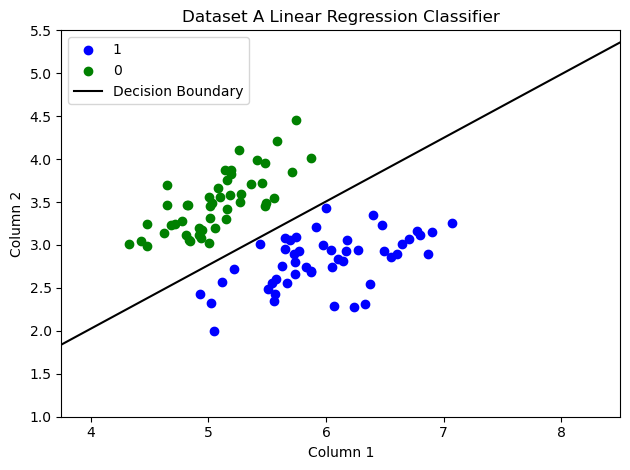

In [68]:
# initialize data
X, y = X_A.copy(), y_A.copy()
X = np.column_stack((np.ones(X.shape[0]), X))

# compute pseudo-inverse of X
X_pseudo_inverse = np.linalg.inv(X.T @ X) @ X.T

# compute weights
weights = X_pseudo_inverse @ y
print(f"W: {weights}")

# cpmpute predictions & convert
y_pred = X @ weights
y_classified = np.sign(y_pred)

# calculte in-sample error (MSE)
E_in = np.mean((y_classified - y) ** 2)
print(f"In-Sample Error: {E_in}")


# scatter plot of data points
plt.scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
plt.scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')

# compute & plot decision boundary
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(weights[0] + weights[1] * x1_vals) / weights[2]
plt.plot(x1_vals, x2_vals, 'k-', label="Decision Boundary")

plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("Dataset A Linear Regression Classifier")
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend()
plt.tight_layout()
plt.show()


#### 1-b

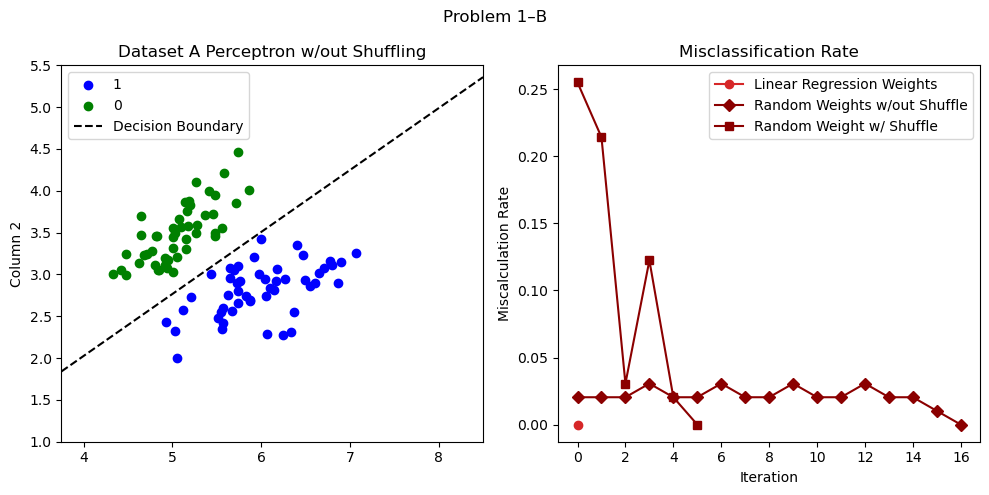

In [69]:
# initialize data
X, y = X_A.copy(), y_A.copy()
X = np.column_stack((np.ones(X.shape[0]), X))

# linear reg for initial weights
X_pseudo_inverse = np.linalg.inv(X.T @ X) @ X.T
init_weights = X_pseudo_inverse @ y

seed = 6531

X, y = X_A.copy(), y_A.copy()
# run model
weights, errors = myPerceptron(X, y, init_weights=init_weights, shuffle=True, random_seed=seed)
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# set up figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot dataset
ax[0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0].set_ylabel('Column 2')
ax[0].legend()
ax[0].set_title('Dataset A Perceptron w/out Shuffling')
ax[0].set_xlim(x1_min, x1_max)
ax[0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[1].plot(errors, marker='o', linestyle='-', color='tab:red', label='Linear Regression Weights')

# run model
weights, errors = myPerceptron(X, y, shuffle=False, random_seed=seed)
ax[1].plot(errors, marker='D', linestyle='-', color='darkred', label='Random Weights w/out Shuffle')
weights, errors = myPerceptron(X, y, shuffle=True, random_seed=seed)
ax[1].plot(errors, marker='s', linestyle='-', color='darkred', label='Random Weight w/ Shuffle')


ax[1].set_ylabel('Miscalculation Rate')
ax[1].set_xlabel('Iteration')
ax[1].set_title('Misclassification Rate')
ax[1].legend()


plt.suptitle('Problem 1–B')
plt.tight_layout()
plt.show()

### Problem 2
#### 2-a

Text(0.5, 1.0, 'Average Misclassification Rate = 0.5049')

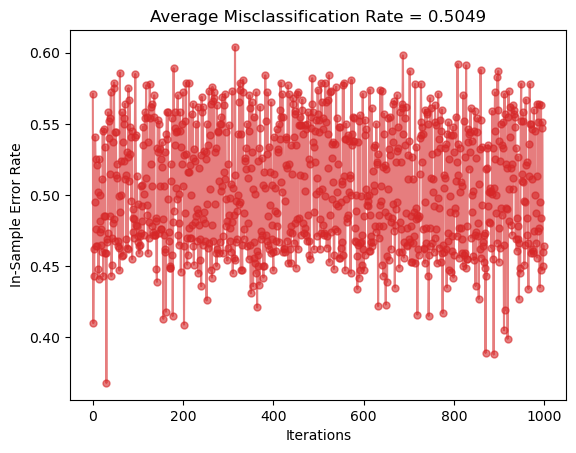

In [70]:
def run_experiment_a(N=1000):    
    # generate training set
    X = np.random.uniform(-1, 1, (N, 2))

    # calculate  f(X=training set) 
    f = np.sign(np.sum(X**2, axis=1) - 0.6)
    # sample 10% of X's indices to flip
    noise_indices = np.random.choice(N, size=int(0.1 * N), replace=False)
    # flip labels
    f[noise_indices] *= -1

    # Add bias term to feature matrix
    X_bias = np.column_stack((np.ones(N), X))

    # Compute weights using linear regression: W = (X^T X)^(-1) X^T Y
    W = np.linalg.pinv(X_bias) @ f

    # Compute in-sample error Ein
    Y_pred = np.sign(X_bias @ W)
    Ein = np.mean(Y_pred != f)
    
    return Ein

errors = []
for i in range(1000):
    errors.append(run_experiment_a(N=1000))

plt.plot(errors, marker='o', markersize=5, alpha=0.6, color='tab:red')
plt.xlabel('Iterations')
plt.ylabel('In-Sample Error Rate')
plt.title(f'Average Misclassification Rate = {round(np.mean(errors), 4)}')

#### 2-b

In [71]:
def run_experiment_b(N=1000):    
    # generate training set
    X = np.random.uniform(-1, 1, (N, 2))

    # calculate  f(X=training set) 
    f = np.sign(np.sum(X**2, axis=1) - 0.6)
    # sample 10% of X's indices to flip
    noise_indices = np.random.choice(N, size=int(0.1 * N), replace=False)
    # flip labels
    f[noise_indices] *= -1

    ### nonlinear transformation: (1, x1, x2, x1*x2, x1^2, x2^2)
    X_transformed = np.column_stack((
        np.ones(N), X[:, 0], X[:, 1], X[:, 0]*X[:, 1], X[:, 0]**2, X[:, 1]**2
    ))

    # Compute weights using linear regression: W = (X^T X)^(-1) X^T Y
    W = np.linalg.pinv(X_transformed) @ f
    
    return W

weights = []
for i in range(1000):
    weights.append(run_experiment_b(N=1000))

weights = np.array(weights)

intercept = np.mean(weights[:, 0])
w1 = np.mean(weights[:, 1])
w2 = np.mean(weights[:, 2])
w3 = np.mean(weights[:, 3])
w4 = np.mean(weights[:, 4])
w5 = np.mean(weights[:, 5])

print(f'   Intercept: {intercept}')
print(f'   x1 weight: {w1}')
print(f'   x2 weight: {w2}')
print(f'x1*x2 weight: {w3}')
print(f'x1**2 weight: {w4}')
print(f'x2**2 weight: {w5}')

   Intercept: -0.9922694808679853
   x1 weight: -0.00045413636469399273
   x2 weight: -0.0018616627730351104
x1*x2 weight: 0.00038221023084607155
x1**2 weight: 1.559206773190692
x2**2 weight: 1.5558083141809937


### Problem 3
#### 3-a

In [72]:
def run_coin_experiment(N=1000, n=10):
    # flip all N coins, n times: 0 = tails; 1 = heads
    flips = np.random.randint(0, 2, (N, n))

    # count # of heads for each row (ie each coin)
    heads = flips.sum(axis=1)

    # get ratio of heads
    v1 = heads[0] / n   # v1 for 1st coin c1
    vrand = heads[np.random.randint(0, N)] / n  # vrand
    vmin_index = np.argmin(heads)
    vmin = heads[vmin_index] / n   # vmin 

    return v1, vrand, vmin

# initialize
experiment_n = 100000
v1_vals, vrand_vals, vmin_vals = [], [], []
for i in range(experiment_n):
    v1, vrand, vmin = run_coin_experiment()
    v1_vals.append(v1)
    vrand_vals.append(vrand)
    vmin_vals.append(vmin)

v1_mean = np.mean(v1_vals)
vrand_mean = np.mean(vrand_vals)
vmin_mean = np.mean(vmin_vals)
print(f'v1 mean: {v1_mean}')
print(f'vrand mean: {vrand_mean}')
print(f'vmin mean: {vmin_mean}')

v1 mean: 0.49948199999999987
vrand mean: 0.49969800000000003
vmin mean: 0.037504
